In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "GPU-d331e3e2-4314-0785-e2af-1ed0812b0c84"

In [2]:
%load_ext autoreload
%autoreload 2

from gwak.train.dataloader import SignalDataloader
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import lightning.pytorch as pl
import yaml
from tqdm import tqdm
from ml4gw.transforms import SpectralDensity, Whiten
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

/home/hongyin.chen/anti_gravity/gwak/gwak/data/prior.py:5: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [3]:
device = "cuda:0"

In [24]:
# data_dir = "/home/katya.govorkova/gwak2/gwak/output/O4_MDC_background/HL/test"
data_dir = "/home/hongyin.chen/Data/GWAK_data/gwak_inspect_4K"
sample_rate = 4096
kernel_length = 0.5
psd_length = 64
fduration = 1
fftlength = 2
batch_size = 1024
batches_per_epoch = 500
num_workers = 2
data_saving_file = None
duration = fduration + kernel_length

from gwak.data.prior import SineGaussianBBC, LAL_BBHPrior, GaussianBBC, CuspBBC, KinkBBC, KinkkinkBBC, WhiteNoiseBurstBBC
from ml4gw.waveforms import SineGaussian, IMRPhenomPv2, Gaussian, GenerateString, WhiteNoiseBurst

signal_classes = [
    "SineGaussian",
    "BBH",
    "Gaussian",
    "Cusp",
    "Kink",
    "KinkKink",
    "WhiteNoiseBurst",
    "Background"
]
priors = [
    SineGaussianBBC(),
    LAL_BBHPrior(),
    GaussianBBC(),
    CuspBBC(),
    KinkBBC(),
    KinkkinkBBC(),
    WhiteNoiseBurstBBC(),
    None
]
waveforms = [
    SineGaussian(
        sample_rate=sample_rate,
        duration=duration
    ),
    IMRPhenomPv2(),
    Gaussian(
        sample_rate=sample_rate,
        duration=duration
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    WhiteNoiseBurst(
        sample_rate=sample_rate,
        duration=duration
    ),
    None
]
extra_kwargs = [
    None,
    {"ringdown_duration":0.9},
    None,
    None,
    None,
    None,
    None,
    None
]

In [25]:
loader = SignalDataloader(signal_classes,
    priors,
    waveforms,
    extra_kwargs,
    data_dir=data_dir,
    sample_rate=sample_rate,
    kernel_length=kernel_length,
    psd_length=psd_length,
    fduration=fduration,
    fftlength=fftlength,
    batch_size=batch_size,
    batches_per_epoch=batches_per_epoch,
    num_workers=num_workers,
    data_saving_file=data_saving_file
)
test_loader = loader.test_dataloader()

/home/hongyin.chen/miniconda3/envs/gwak_dev/lib/python3.11/site-packages/ml4gw/dataloading/hdf5_dataset.py:83: ContiguousHdf5Warning: File /home/hongyin.chen/Data/GWAK_data/gwak_inspect_4K/background-1402860176-40556.h5 contains datasets that were generated without using chunked storage. This can have severe performance impacts at data loading time. If you need faster loading, try re-generating your datset with chunked storage turned on.
  warnings.warn(


In [26]:
device

'cuda:0'

In [ ]:
embed_model_path = "/home/hongyin.chen/anti_gravity/gwak/gwak/output/S4_SimCLR_multiSignalAndBkg_HL/model_JIT.pt"
embed_model = torch.jit.load(embed_model_path).to(device)
embed_model.eval()

metric_model_path = "/home/hongyin.chen/anti_gravity/gwak/gwak/output/S4_SimCLR_multiSignalAndBkg_NF_onlyBkg_HL/model_JIT.pt"
metric_model_path = "/home/katya.govorkova/gwak2/gwak/output/S4_SimCLR_multiSignalAndBkg_NF_onlyBkg_HL/model_JIT.pt"
metric_model = torch.jit.load(metric_model_path).to(device)
metric_model.eval()

combined_model_path = "/home/hongyin.chen/anti_gravity/gwak/gwak/output/combination/model_JIT.pt"
combined_model = torch.jit.load(combined_model_path).to(device)
combined_model.eval()

# Containers to store anomaly scores and binary labels
all_scores = []
c_all_scores = []
all_binary_labels = []
all_labels = []
all_snrs = []
all_embeddings = []

# Iterate over the test data loader
niter = 1
for ib in range(niter):
    print(f"iter {ib+1}/{niter}")
    for batch in tqdm(test_loader):
        [batch] = batch
        # Generate the corresponding waveforms
        waveforms, params, ras, decs, phics = loader.generate_waveforms(batch.shape[0])
        batch = batch.to(device)

        # Process the waveforms into the required input format
        x, snrs = loader.multiInject_SNR(waveforms, batch)

        # Reconstruct the ground truth multi-class labels
        labels = torch.cat([(i+1)*torch.ones(loader.num_per_class[i]) for i in range(loader.num_classes)]).to(device)

        with torch.no_grad():
            # print(x)
            z = embed_model(x.to(device))
            # print(f"{z = }")
            scores = metric_model(z).squeeze().cpu().numpy()
            # print(f"{scores = }")
            # The combined model directly outputs the anomaly score

            c_scores = combined_model(x.to(device)).squeeze().cpu().detach().numpy()
            #scores = combined_model(x.to(device)).squeeze()  # (batch_size,)
            #scores = scores.cpu().numpy()
            # Invert the scores so that higher values correspond to more anomalous behavior
            scores = -scores
            c_scores = -c_scores

        # Convert the multi-class labels to binary labels:
        # Treat "Background" (assumed to be label 8) as 0 (normal) and all other classes as 1 (anomaly)
        binary_labels = (labels != 8).cpu().numpy()

        all_scores.append(scores)
        c_all_scores.append(c_scores)
        all_binary_labels.append(binary_labels)
        all_labels.append(labels.cpu().numpy())
        all_snrs.append(snrs.cpu().numpy())
        all_embeddings.append(z.cpu().detach().numpy())

# Concatenate scores and labels across batches
all_scores = np.concatenate(all_scores)
c_all_scores = np.concatenate(c_all_scores)
all_binary_labels = np.concatenate(all_binary_labels)
all_labels = np.concatenate(all_labels)
all_snrs = np.concatenate(all_snrs)
all_embeddings = np.concatenate(all_embeddings)

iter 1/1


  0%|          | 0/500 [00:00<?, ?it/s]

tensor([[[-0.7378,  0.6774,  0.0046,  ...,  1.8396,  1.2104, -0.2777],
         [ 0.4780,  0.7082,  1.2748,  ...,  0.8279, -1.5465, -1.4053]],

        [[ 0.2610,  0.2551,  0.3778,  ...,  0.7024, -1.2453, -0.8903],
         [ 0.9513,  0.1331,  1.5263,  ..., -1.1409,  2.2220,  0.4603]],

        [[ 0.0764,  0.2702,  0.9654,  ...,  0.1243, -0.3974, -0.0388],
         [ 1.4953, -0.0237, -0.5032,  ...,  0.7695, -0.7169,  0.2434]],

        ...,

        [[ 1.0302,  0.1097, -1.1081,  ..., -0.1021, -1.6328,  0.6210],
         [-0.0235, -0.3446,  0.6924,  ..., -0.3323, -1.5200,  0.7783]],

        [[-0.9370, -1.3838, -0.1314,  ...,  0.8196,  0.0338, -2.2854],
         [ 1.5472,  0.7544,  0.2628,  ..., -0.0691,  0.3511,  0.3970]],

        [[-1.2674,  1.1879,  0.0767,  ..., -0.7187,  1.0139, -1.6548],
         [ 0.0352,  0.1149,  0.8515,  ...,  0.6081,  0.5842,  0.7199]]],
       device='cuda:0')
z = tensor([[-1.9040, -0.4859, -1.5477,  ..., -0.3127, -0.8652,  0.2787],
        [-1.8616, -0.433

  0%|          | 1/500 [00:16<2:20:41, 16.92s/it]

tensor([[[-0.9566,  0.9674,  1.5299,  ...,  0.8454,  0.9162, -0.9163],
         [-1.2896,  1.0783, -0.6687,  ..., -0.1159, -0.7080,  0.5740]],

        [[ 0.3558,  0.7475, -1.4223,  ..., -0.5325, -0.3794,  0.3646],
         [ 0.2873,  0.7792,  0.5898,  ..., -0.1233,  1.3435, -0.0810]],

        [[ 0.6919, -0.3521, -0.3785,  ..., -1.6418, -0.4699,  0.8781],
         [-1.4078,  1.4299, -0.3223,  ...,  1.0049,  1.1405,  0.6840]],

        ...,

        [[-0.0935,  1.0227,  1.3352,  ..., -0.0302, -0.7527,  0.6883],
         [-1.2051, -0.7197,  0.1247,  ..., -0.5741,  0.0039, -0.9298]],

        [[-0.1190,  0.5345,  0.3986,  ..., -0.4458, -0.7977, -1.4505],
         [-0.8108,  2.5494, -0.4871,  ..., -0.0854, -0.5287, -1.6694]],

        [[ 0.1740, -0.8036,  1.8865,  ..., -0.0823, -0.0294, -1.7854],
         [-0.7166, -0.1972, -0.3083,  ..., -0.3574,  0.8940,  1.4574]]],
       device='cuda:0')
z = tensor([[-1.8723, -0.4286, -1.6645,  ..., -0.3471, -0.8494,  0.2651],
        [-1.8756, -0.521

  0%|          | 2/500 [00:27<1:50:00, 13.25s/it]

tensor([[[-0.3865, -1.0595,  0.8014,  ...,  0.5771, -0.6524, -1.0792],
         [ 2.4508, -1.0349, -1.9281,  ...,  2.1859,  0.5491, -0.6635]],

        [[-0.4928, -0.4939,  0.4710,  ...,  1.2622, -0.0720,  0.3067],
         [ 1.1402, -0.0687,  2.0144,  ..., -0.8577, -2.1758,  1.2654]],

        [[-0.1016,  1.6846,  0.3970,  ..., -1.5210, -1.2039, -0.0579],
         [-0.7296, -0.4649,  0.0326,  ...,  0.0824, -0.5318, -2.4276]],

        ...,

        [[ 0.6575,  1.2644, -0.4181,  ..., -0.5776, -0.5569,  1.0303],
         [-1.9968,  0.7511, -0.3063,  ...,  1.0651,  1.1397, -1.4531]],

        [[-1.7496,  1.4068, -0.3883,  ...,  1.6156, -0.3628, -1.5304],
         [-0.2878, -1.2984, -1.7549,  ...,  0.4691, -0.3458,  0.6447]],

        [[ 0.3531,  1.2920, -1.3578,  ...,  0.6771,  2.1970,  1.1774],
         [ 0.8527,  1.7285, -0.8204,  ..., -0.3897, -2.2035, -0.9075]]],
       device='cuda:0')
z = tensor([[-1.8803, -0.5012, -1.5812,  ..., -0.2871, -0.9195,  0.2552],
        [-1.8760, -0.522

  1%|          | 3/500 [00:37<1:35:46, 11.56s/it]

tensor([[[-1.0414, -0.4170, -0.5527,  ...,  0.0158,  1.0390, -0.6335],
         [ 0.3259, -0.4317,  1.1498,  ...,  2.7735, -0.2626,  0.8484]],

        [[ 1.5692, -0.7472, -1.1228,  ...,  0.5011, -1.3782,  1.4404],
         [-1.2024,  2.2576,  0.6818,  ..., -1.8255,  1.3293, -0.1086]],

        [[-0.3020, -1.3575, -0.9031,  ...,  0.6633,  1.2221,  0.1219],
         [ 0.0360, -1.4041,  1.2158,  ...,  0.4134, -0.7761,  0.3677]],

        ...,

        [[-1.2040, -0.2911,  1.1779,  ..., -0.5327, -0.7977, -0.4536],
         [ 0.8706,  1.0536,  0.6032,  ..., -0.5185, -1.9570, -0.7524]],

        [[-1.8706,  1.7206, -0.7658,  ...,  0.1792,  0.2423,  2.2244],
         [-1.0892, -0.1341, -0.3861,  ...,  1.0837, -0.3511,  1.2317]],

        [[ 0.8368, -1.1898, -1.1364,  ..., -1.5535, -2.0450, -0.2751],
         [ 0.0144, -0.8169,  0.7353,  ...,  1.3050, -0.6618, -0.3840]]],
       device='cuda:0')
z = tensor([[-1.8488, -0.3605, -1.7879,  ..., -0.4129, -0.7894,  0.2660],
        [-1.8958, -0.541

  1%|          | 4/500 [00:46<1:28:41, 10.73s/it]

tensor([[[-1.5029, -0.9019,  1.8120,  ..., -1.1587, -2.3726,  0.4345],
         [ 0.1450,  0.2017, -0.0340,  ..., -0.6410, -0.3540, -0.0353]],

        [[ 0.3227,  0.2683,  0.5082,  ..., -1.2858, -0.4217, -0.1169],
         [-1.7290, -0.2116,  1.2121,  ...,  0.7465,  0.9870, -0.2142]],

        [[ 1.3478, -1.4823,  0.1187,  ...,  0.2660,  0.8493, -0.4925],
         [ 1.2754,  0.6335,  1.1917,  ...,  0.1558, -0.1741, -0.4628]],

        ...,

        [[-0.0085, -1.8381, -0.6925,  ...,  1.2533, -1.0920, -0.0529],
         [-0.3032,  0.3307,  0.9150,  ...,  0.4884, -0.0907,  0.4609]],

        [[ 0.7279,  1.6404,  1.4069,  ...,  0.1810,  0.3890,  0.5003],
         [ 0.5368,  1.0161,  1.1343,  ..., -0.3588, -1.3102, -1.0086]],

        [[ 0.4561,  0.7390, -2.6012,  ..., -0.5818, -0.7295, -0.3594],
         [ 1.2804,  1.3377,  2.1191,  ..., -1.1022,  0.7475, -0.5559]]],
       device='cuda:0')
z = tensor([[-1.8842, -0.5040, -1.5830,  ..., -0.2809, -0.9198,  0.2467],
        [-1.9871, -0.638

  1%|          | 5/500 [00:56<1:25:47, 10.40s/it]

tensor([[[ 0.1225,  0.9671, -0.4616,  ..., -0.5124, -0.5663,  1.4746],
         [-1.6021, -1.2456,  1.6053,  ...,  1.6809, -0.4390,  0.1698]],

        [[ 0.2395,  0.3437,  0.1698,  ..., -0.8309, -0.0827, -0.5295],
         [ 0.5899, -0.2953, -1.1713,  ...,  0.8094, -0.4131,  0.3378]],

        [[ 0.3802, -0.7190, -0.8384,  ..., -0.3161,  1.6307, -0.4999],
         [-0.4674,  0.0296, -0.2633,  ..., -0.0836,  0.3222,  1.5589]],

        ...,

        [[-0.0148,  2.4612,  0.7411,  ..., -2.0342, -0.2162,  0.0377],
         [ 1.1999,  1.1720,  0.2972,  ..., -0.3426,  0.5465,  0.5844]],

        [[ 0.0921, -0.2317,  0.1862,  ...,  0.6734,  0.1418,  0.7394],
         [ 1.6688,  0.4362, -0.5798,  ..., -0.2656, -0.5595,  1.5683]],

        [[-0.4608,  1.0806, -0.4795,  ...,  0.1653,  1.2269,  0.7306],
         [-0.0757,  0.0213, -0.6155,  ..., -2.1051,  1.6829, -0.5190]]],
       device='cuda:0')
z = tensor([[-1.8868, -0.5025, -1.5652,  ..., -0.2795, -0.9176,  0.2496],
        [-1.8629, -0.434

  1%|          | 6/500 [01:06<1:23:35, 10.15s/it]

tensor([[[-0.1068,  0.3102, -0.8103,  ..., -1.0719,  0.3441,  0.3744],
         [-0.7343, -0.5892,  0.2034,  ..., -0.7034,  0.0413,  0.6231]],

        [[ 1.3167, -0.1474, -1.1626,  ...,  0.0649,  0.6625, -1.0422],
         [-1.7829, -0.6920, -0.5449,  ...,  0.6174,  0.0932,  0.9247]],

        [[ 0.5626, -0.1378, -1.5581,  ..., -0.8577, -0.0181,  1.6853],
         [ 0.5185, -1.0276,  0.0978,  ..., -1.3614,  0.2804, -0.1322]],

        ...,

        [[ 0.1042, -0.3513, -1.9665,  ...,  0.0135,  1.0452,  1.4288],
         [ 1.6628,  0.6290, -0.9816,  ..., -0.0034,  1.6556,  1.9323]],

        [[ 0.8506,  0.0624,  0.4449,  ...,  0.9825, -1.2211, -2.3268],
         [ 1.1024,  0.8316,  0.4558,  ..., -0.2460, -1.4893, -1.4044]],

        [[-0.1255, -0.2533, -0.7853,  ...,  0.8173, -0.4901, -1.2463],
         [ 0.5586,  0.1729,  3.0145,  ...,  0.0477, -0.0093, -0.9570]]],
       device='cuda:0')
z = tensor([[-1.9284, -0.5612, -1.4170,  ..., -0.2630, -0.9142,  0.2901],
        [-1.9455, -0.385

  1%|▏         | 7/500 [01:15<1:21:56,  9.97s/it]

tensor([[[ 1.0134e+00, -1.0957e+00, -9.0199e-01,  ..., -9.9902e-01,
          -1.1178e-01, -4.4155e-01],
         [-2.4471e+00,  1.5445e-01, -1.8544e+00,  ...,  1.0248e+00,
          -3.5417e-01,  1.4728e+00]],

        [[ 1.2923e+00, -7.2861e-01, -1.3599e+00,  ..., -1.8158e+00,
          -6.1631e-01,  7.5755e-01],
         [-6.2781e-02,  3.7326e-01,  4.7380e-01,  ..., -1.1146e+00,
           1.3201e+00, -1.0593e+00]],

        [[-1.2043e+00,  1.8331e-01, -5.9971e-01,  ...,  3.9967e-01,
          -3.4187e-03, -1.1174e+00],
         [-1.0563e+00,  8.9197e-01,  1.9753e-01,  ..., -1.2326e+00,
           7.4306e-01,  5.4996e-02]],

        ...,

        [[-1.6493e+00,  1.0908e+00,  1.5126e+00,  ...,  3.2328e-01,
          -1.6290e-01, -3.0383e-01],
         [ 1.3861e+00, -8.6985e-01,  2.0670e-01,  ..., -2.9727e+00,
          -1.6179e+00, -1.5469e+00]],

        [[-8.2278e-01,  1.1080e+00, -2.9198e-02,  ..., -2.2517e-01,
           1.8413e+00, -1.9675e-01],
         [ 7.1379e-01, -4.5731e-0

  2%|▏         | 8/500 [01:25<1:21:01,  9.88s/it]

tensor([[[-0.6812,  1.5651, -1.0879,  ...,  0.5065,  1.2598,  0.2751],
         [ 0.9401, -2.4428,  2.1130,  ...,  0.6500,  0.2692,  2.0929]],

        [[-1.0417, -0.0257, -1.9523,  ...,  0.8433,  0.5063, -0.7924],
         [-1.8306,  0.4042, -0.2638,  ..., -0.2147,  0.2944,  1.2240]],

        [[-0.0411,  0.6868, -0.1307,  ..., -0.4738, -0.6681,  0.6039],
         [ 1.4862,  1.3123, -0.2032,  ...,  1.5355,  0.1171, -1.0653]],

        ...,

        [[-0.1915, -1.3277, -0.5930,  ...,  0.5470,  0.6695, -0.2118],
         [-1.0097,  1.4682, -2.0610,  ...,  1.3134,  0.5084,  0.4258]],

        [[ 0.6060,  2.8348, -1.0827,  ...,  0.2297, -0.3757,  1.0080],
         [-0.1494, -1.5145,  0.8145,  ..., -0.5272, -1.9636,  0.0965]],

        [[-0.7228, -1.7914,  0.2821,  ...,  0.9237,  2.1821, -0.4059],
         [-0.8246, -0.5500,  1.3792,  ..., -0.0663,  2.1049, -0.2923]]],
       device='cuda:0')
z = tensor([[-1.8920, -0.5085, -1.5545,  ..., -0.2789, -0.9150,  0.2612],
        [-1.9002, -0.548

  2%|▏         | 9/500 [01:35<1:20:45,  9.87s/it]

tensor([[[-0.1141, -1.1715,  0.3945,  ..., -0.0382, -0.8831,  0.2159],
         [ 0.4453, -1.1707,  0.2417,  ..., -1.4417, -1.5473,  1.1010]],

        [[-0.8246,  0.3536,  0.4426,  ..., -0.4081, -0.7308, -0.2260],
         [-0.8120,  0.2529,  1.3701,  ...,  0.7761,  0.4778,  1.9320]],

        [[-1.1662,  1.3099,  0.2704,  ..., -0.1942,  1.2841, -0.2623],
         [-1.0476, -1.4860,  1.0657,  ...,  1.1438, -1.0875, -0.3183]],

        ...,

        [[-0.7754, -0.8220, -1.8495,  ...,  1.2612, -0.9969,  0.5193],
         [-1.8487, -1.5619,  0.8941,  ..., -0.5516,  0.0749,  0.9966]],

        [[-1.6325,  1.3719, -0.0462,  ..., -0.8033, -0.5331,  1.0846],
         [-2.1540, -0.6670,  0.8918,  ...,  0.1808,  1.8029, -1.7113]],

        [[-0.8892,  0.3600,  0.4377,  ...,  0.2280, -0.7584,  0.8935],
         [ 0.1453, -1.6689, -2.6850,  ...,  0.9950, -0.6482,  0.2479]]],
       device='cuda:0')
z = tensor([[-1.8516, -0.4253, -1.6995,  ..., -0.3364, -0.8594,  0.2517],
        [-1.9016, -0.460

  2%|▏         | 10/500 [01:44<1:20:10,  9.82s/it]

tensor([[[ 0.5955,  1.0814,  0.6229,  ..., -0.9879,  0.1652,  0.5662],
         [-0.7047, -0.0854,  0.1323,  ..., -0.5112,  0.8214,  0.5936]],

        [[-0.3533, -0.4293, -0.2115,  ..., -0.2206,  0.0039,  1.0220],
         [-0.4111, -0.6753, -0.6872,  ...,  1.3596,  1.3854,  2.7045]],

        [[-0.6607, -0.1713,  0.2140,  ..., -0.2170,  1.3964,  0.2421],
         [-0.2062,  0.2620,  0.5558,  ..., -0.0648,  0.1995, -0.6183]],

        ...,

        [[ 0.6982, -1.7629,  0.0897,  ..., -0.3471, -0.6377, -0.0916],
         [ 0.5217,  1.5420,  2.4505,  ..., -0.8896, -1.7460,  0.4111]],

        [[-0.3205, -2.2120, -1.8396,  ...,  0.4302,  0.6880, -0.4140],
         [ 1.4773,  1.3154,  0.7901,  ..., -0.9686,  0.3120, -0.4384]],

        [[-0.5309, -0.1047,  2.4755,  ..., -0.3052, -0.0641, -0.1725],
         [-2.9149, -0.0119, -0.6905,  ...,  1.2716,  1.3313,  1.2956]]],
       device='cuda:0')
z = tensor([[-1.8887, -0.5006, -1.5709,  ..., -0.2827, -0.9160,  0.2570],
        [-2.0210, -0.743

  2%|▏         | 11/500 [01:54<1:19:48,  9.79s/it]

tensor([[[-1.8239e-01,  9.3584e-02, -1.9252e+00,  ...,  2.6298e-01,
           3.9740e-01, -1.4281e+00],
         [-3.5028e-01, -2.4400e-01, -3.1915e+00,  ...,  2.1603e+00,
           1.8214e+00, -4.9698e-01]],

        [[ 2.8740e-01, -4.0978e-01,  2.4541e-02,  ..., -4.1259e-01,
           1.1253e+00,  8.3786e-01],
         [ 8.1956e-01, -5.8245e-01, -8.6171e-01,  ..., -1.0829e+00,
           2.2401e-02, -3.8135e-01]],

        [[-1.7719e+00,  1.2670e+00,  1.6389e+00,  ..., -7.9652e-01,
          -9.7979e-01,  2.9350e-01],
         [-2.8928e-01, -4.6116e-01,  5.2807e-01,  ..., -6.1994e-01,
           2.2033e-01,  5.2001e-01]],

        ...,

        [[-1.0530e+00, -4.4083e-01, -5.8904e-01,  ..., -5.6047e-02,
          -1.2026e+00, -1.3143e+00],
         [-3.5803e-01,  2.0323e-03, -1.5268e+00,  ...,  5.0686e-01,
          -1.8470e-01, -2.2911e-01]],

        [[-1.3781e+00,  5.1149e-01,  8.6710e-01,  ..., -4.1899e-01,
           4.1254e-01, -4.6054e-01],
         [ 7.4201e-01,  7.4792e-0

  2%|▏         | 12/500 [02:05<1:21:12,  9.98s/it]

tensor([[[ 0.1050,  1.1615, -1.3561,  ...,  0.6620, -0.5327, -0.3137],
         [-1.2869, -0.3024,  1.5337,  ...,  0.6572, -0.4106, -1.8678]],

        [[-0.5941,  0.6019, -0.6387,  ...,  1.4108, -2.0012,  2.1945],
         [-1.1369, -1.2759, -0.7690,  ...,  0.9781,  0.4890,  0.2804]],

        [[ 0.9296,  0.3167, -0.0920,  ..., -0.1113, -0.8332,  0.4688],
         [-0.3061,  0.6262,  0.0132,  ...,  0.1755,  0.3568, -1.0886]],

        ...,

        [[-0.2456, -1.6148,  0.8873,  ...,  0.8834,  0.9035, -0.0863],
         [-1.1247, -1.1257,  1.5472,  ...,  0.3736, -0.1466,  0.6295]],

        [[-1.2935, -0.1637,  0.9067,  ...,  2.8768, -1.9982,  0.3664],
         [-1.7015,  0.1903, -0.7173,  ...,  1.6433, -0.5155,  0.3615]],

        [[ 1.7270,  1.1316,  0.1458,  ...,  1.3707, -1.7988, -0.3842],
         [ 0.7498,  0.0054, -0.0896,  ...,  0.4629, -0.4239, -0.6515]]],
       device='cuda:0')
z = tensor([[-1.8668, -0.3534, -1.7560,  ..., -0.4333, -0.7651,  0.2804],
        [-1.9070, -0.549

  3%|▎         | 13/500 [02:15<1:21:23, 10.03s/it]

tensor([[[-0.8513,  0.3731,  0.2319,  ..., -0.2972,  0.4231, -0.4503],
         [ 1.3901, -0.7690,  1.3456,  ..., -0.6555,  0.8396, -0.7806]],

        [[-1.0244,  0.0774,  0.7294,  ..., -0.5674, -1.2871, -0.3209],
         [-2.1906, -3.0298,  0.3282,  ..., -1.3136, -0.6964, -0.2291]],

        [[-0.9658,  0.6251,  0.8675,  ..., -1.8919, -0.1625,  0.4421],
         [-0.2467,  0.1119, -0.8136,  ..., -1.6972, -0.6511,  0.1378]],

        ...,

        [[-1.2214,  0.7327, -0.4810,  ...,  0.0987, -0.0971,  0.4705],
         [-0.9129, -0.0058, -0.3756,  ..., -2.1076,  0.1381, -0.6120]],

        [[ 0.4168, -1.1059,  0.2078,  ..., -0.7250, -1.3377,  1.1923],
         [-0.2983, -0.2419, -0.3640,  ...,  0.6665,  0.2849,  0.2264]],

        [[ 0.0111, -0.8973,  1.1387,  ..., -0.1518, -1.2285,  0.1563],
         [ 2.3367, -0.3058,  0.9689,  ..., -1.4437,  1.2058, -0.6608]]],
       device='cuda:0')
z = tensor([[-1.8360, -0.3586, -1.7940,  ..., -0.4037, -0.7947,  0.2612],
        [-1.8933, -0.526

  3%|▎         | 14/500 [02:25<1:21:39, 10.08s/it]

tensor([[[ 0.2519,  0.1104,  0.6106,  ...,  0.8143, -0.9462, -0.5656],
         [ 0.0655,  0.3292,  0.6264,  ...,  1.3389,  0.1549,  0.5403]],

        [[ 0.2810,  0.2252,  0.6315,  ..., -2.4174, -0.6257, -0.8808],
         [ 0.2415,  0.5397, -0.0985,  ...,  0.7186,  0.0841,  1.1337]],

        [[ 1.3934, -0.3123,  0.8435,  ...,  0.8360,  0.1645,  0.9664],
         [ 1.1655,  0.9851, -0.8144,  ...,  0.5313, -0.4425, -1.8646]],

        ...,

        [[ 2.1218,  0.1823, -0.1874,  ...,  0.3989,  1.1911,  1.7727],
         [ 1.9876, -2.0852, -0.0685,  ..., -0.2966, -0.9535,  0.9523]],

        [[ 0.3394, -0.0049, -0.7125,  ...,  1.4453,  0.5762, -0.8862],
         [-0.6423, -1.2083, -0.2385,  ...,  0.1116, -0.3697,  0.7924]],

        [[-0.2669, -1.4566, -1.0961,  ...,  0.6323, -1.2590, -1.3352],
         [ 1.8383, -0.9572, -1.1205,  ...,  0.0705,  0.2447,  1.0278]]],
       device='cuda:0')
z = tensor([[-1.8554, -0.4230, -1.6600,  ..., -0.3458, -0.8351,  0.2677],
        [-1.9028, -0.566

  3%|▎         | 15/500 [02:35<1:21:18, 10.06s/it]

tensor([[[-0.5215, -1.0872,  1.1445,  ...,  0.6258, -0.9237, -2.1780],
         [ 0.6031, -1.7793, -0.4762,  ...,  1.1427, -0.1856,  0.6890]],

        [[-0.8422, -1.4117, -0.1062,  ..., -1.1048, -1.8965, -2.1852],
         [-1.9306, -1.5766, -1.1488,  ...,  0.2176, -1.1219,  0.4166]],

        [[ 0.0668,  1.5062,  0.6480,  ..., -0.3899,  0.5662,  2.1162],
         [-0.8033, -0.4061,  1.0123,  ...,  1.2143,  0.8442, -1.1952]],

        ...,

        [[ 0.9171, -0.3490, -0.8706,  ..., -1.0089,  1.3490, -0.6361],
         [-1.6661,  3.1522,  0.2477,  ..., -0.0892, -2.1677, -0.2141]],

        [[ 0.3568, -0.2009,  0.0880,  ..., -2.0852,  0.4039, -0.2991],
         [ 1.4941, -2.0886,  0.0766,  ..., -0.5272,  1.0165, -0.5843]],

        [[ 0.2954, -0.2426,  0.2473,  ...,  0.3986,  0.7386,  0.0908],
         [-0.0895,  0.2787,  0.2666,  ...,  0.8349,  0.0193, -0.2532]]],
       device='cuda:0')
z = tensor([[-1.8682, -0.4297, -1.6820,  ..., -0.3439, -0.8432,  0.2598],
        [-2.7787,  0.016

  3%|▎         | 16/500 [02:45<1:21:32, 10.11s/it]

tensor([[[ 0.5437, -0.7564,  0.8930,  ..., -0.0033,  0.5378, -0.7307],
         [ 0.5882, -0.0078, -0.7878,  ...,  1.2649, -0.9657, -0.0625]],

        [[ 1.4621,  1.0246, -0.5492,  ..., -1.1011,  1.0199,  1.2004],
         [ 0.9574,  0.7602, -1.4860,  ..., -0.0047,  1.3334,  0.2152]],

        [[ 0.6056,  0.2628, -1.6849,  ..., -0.0795, -0.6286,  0.9433],
         [ 0.1855, -1.4300, -0.9865,  ..., -1.5971, -0.6616, -2.2936]],

        ...,

        [[-0.0123, -0.0374,  0.4315,  ..., -1.1787, -0.8382,  1.1694],
         [ 0.8120, -0.2738,  1.0061,  ..., -0.2912, -0.3292,  1.4445]],

        [[ 0.6282, -0.4135, -0.3193,  ...,  0.3075,  0.8039,  0.0795],
         [-0.7931,  0.6488, -0.1954,  ...,  0.1137, -0.9930, -0.2139]],

        [[ 1.3364,  0.6225,  1.5591,  ...,  1.3691, -0.1464, -0.9212],
         [ 1.1600,  0.1930, -0.1222,  ...,  0.1764, -0.1922, -0.1995]]],
       device='cuda:0')
z = tensor([[-1.8768, -0.4899, -1.5737,  ..., -0.3003, -0.8995,  0.2720],
        [-1.8740, -0.486

  3%|▎         | 17/500 [02:55<1:21:13, 10.09s/it]

tensor([[[-1.0174, -0.0970, -0.3831,  ..., -0.3811,  0.1540,  1.1285],
         [-0.0480,  0.2986, -0.0607,  ...,  0.0725, -1.1143, -0.6042]],

        [[-0.6969,  0.6845, -0.7825,  ...,  0.3269, -0.1216,  1.0106],
         [-1.3825,  1.0522, -1.0184,  ..., -0.1631,  1.1134, -0.8624]],

        [[ 0.1708,  0.1033,  0.5315,  ...,  0.5981, -0.7136, -0.8016],
         [ 0.8886,  0.2899,  1.4917,  ..., -0.7239,  0.8504, -0.2332]],

        ...,

        [[ 1.8806, -2.2172, -0.7976,  ..., -0.4728,  1.6469,  0.6864],
         [-1.0662, -0.2338,  0.1910,  ...,  1.4227,  0.2938, -0.3279]],

        [[-0.6470, -1.2406, -0.6057,  ...,  0.2876, -0.1147,  0.8136],
         [-0.2672,  1.3696,  0.3082,  ..., -0.0985, -0.7092, -0.0815]],

        [[-0.6934,  0.7594, -0.7164,  ...,  0.1458,  1.2721, -0.1045],
         [-1.3646,  1.0464, -0.9491,  ..., -0.3131, -0.1640,  1.0859]]],
       device='cuda:0')
z = tensor([[-1.9069, -0.4193, -1.7020,  ..., -0.3946, -0.7863,  0.2832],
        [-1.8869, -0.529

  4%|▎         | 18/500 [03:05<1:20:42, 10.05s/it]

tensor([[[ 0.2316, -0.8011, -0.5406,  ...,  0.8220, -1.4180, -2.0379],
         [ 1.3750,  0.4971, -0.1136,  ...,  0.8931,  0.3919, -1.3480]],

        [[ 1.3895,  0.5101, -0.0325,  ...,  0.8112, -0.6950,  0.6041],
         [ 2.3269,  1.4408, -0.5459,  ..., -0.7728,  0.4018, -0.2479]],

        [[-1.0560,  0.0171,  0.1437,  ...,  1.1712, -0.3976,  0.4219],
         [ 1.2536, -0.1516,  0.1070,  ..., -1.5378,  1.1558, -0.7038]],

        ...,

        [[ 0.8017, -1.7023,  0.3979,  ...,  0.9905, -0.6133, -1.6812],
         [-0.9870, -1.7005,  0.1394,  ..., -1.0236,  1.2415,  0.7329]],

        [[ 0.6356, -0.7036,  2.0541,  ..., -0.5720, -1.7344,  1.4987],
         [ 0.0254,  1.3833,  0.8978,  ...,  0.5762,  0.8399, -0.2079]],

        [[ 0.5766, -0.7158, -0.7583,  ...,  1.0687,  1.2590, -2.2702],
         [-0.1184,  0.7058,  1.8910,  ..., -1.0418, -0.0546,  1.0062]]],
       device='cuda:0')
z = tensor([[-1.8871, -0.5064, -1.5618,  ..., -0.2860, -0.9108,  0.2592],
        [-1.8876, -0.482

  4%|▍         | 19/500 [03:15<1:19:18,  9.89s/it]

tensor([[[-0.8726, -0.4762, -1.1417,  ...,  0.9323,  1.1574,  3.1652],
         [ 1.2769,  1.0317,  0.6173,  ..., -0.8051, -0.5287,  1.4631]],

        [[-0.7228,  0.3235, -0.0334,  ...,  0.2114, -1.4431,  0.5310],
         [ 0.3881,  0.2127,  1.3700,  ...,  1.2021, -1.6551, -1.0530]],

        [[-1.3873,  0.2690,  1.3192,  ...,  0.1536,  0.5557,  1.0261],
         [ 1.0456,  0.5324,  0.4975,  ..., -0.4365, -1.5494, -0.5920]],

        ...,

        [[ 0.1114,  0.1578, -1.0440,  ...,  0.1341,  1.0761, -3.0500],
         [ 1.0223, -0.1741, -0.2861,  ...,  1.9915,  0.2278,  1.5795]],

        [[ 1.6152, -1.2107,  1.1169,  ...,  0.8748, -0.4897, -1.7158],
         [-0.9989, -1.1906, -1.3460,  ...,  0.9519, -0.1183, -0.3691]],

        [[ 0.4729, -0.1729, -0.6186,  ...,  0.6734,  2.1849, -0.3513],
         [ 0.0903,  1.2791, -0.1578,  ..., -0.2782,  0.2016,  2.0392]]],
       device='cuda:0')
z = tensor([[-1.8804, -0.4766, -1.5882,  ..., -0.3078, -0.8622,  0.2677],
        [-1.8904, -0.447

  4%|▍         | 20/500 [03:25<1:18:59,  9.87s/it]

tensor([[[ 0.3360, -0.1156,  1.3217,  ..., -1.0577,  0.0454,  1.4319],
         [-2.6460,  1.3054,  0.2103,  ..., -0.2927,  0.8697, -0.0058]],

        [[ 2.2208,  1.2491,  0.0732,  ..., -1.8785,  0.0037,  0.1185],
         [-1.1589, -2.0991, -1.4574,  ...,  1.1483,  0.2777,  1.2894]],

        [[-2.6203, -0.6625, -0.8284,  ..., -0.0712,  1.6570,  1.2551],
         [-0.8007,  1.8455, -1.6022,  ...,  0.8762, -0.3714, -0.1535]],

        ...,

        [[ 1.0147,  1.2510,  0.5488,  ..., -0.7880, -0.1945, -1.7475],
         [ 0.2053, -0.4726,  0.9261,  ..., -0.3443, -1.1413,  0.1781]],

        [[ 0.4717,  0.9837,  1.6442,  ..., -0.7054, -0.0291,  0.3097],
         [-0.7024, -0.1548, -1.0275,  ...,  0.6749, -1.2495,  0.4678]],

        [[ 0.5478, -0.2354, -1.7068,  ...,  1.5201,  1.2154, -0.0354],
         [ 0.5578,  1.6389,  0.0246,  ...,  1.0375, -1.1774,  0.4083]]],
       device='cuda:0')
z = tensor([[-1.9350, -0.6680, -1.3544,  ..., -0.1428, -1.0786,  0.2173],
        [-1.9972, -0.364

  4%|▍         | 21/500 [03:34<1:18:21,  9.82s/it]

tensor([[[ 0.0847, -0.6890, -0.7675,  ..., -2.0807, -0.9416,  0.7270],
         [ 0.1420,  0.0892,  1.3774,  ...,  1.1590, -0.6140, -0.7878]],

        [[-0.4241, -1.8727, -0.2138,  ...,  0.8164, -0.2603,  0.9885],
         [-0.1762, -1.0656,  1.1798,  ..., -0.8774,  0.6592,  0.8606]],

        [[ 1.9479, -1.9363, -0.7652,  ..., -1.1268,  0.2439,  0.6719],
         [-0.2270,  2.0731,  0.2058,  ..., -0.9312,  0.3708,  0.3127]],

        ...,

        [[-0.2237,  0.3179,  0.0766,  ...,  0.3057,  1.4807,  0.8482],
         [ 1.3607,  0.4257, -0.4296,  ...,  0.1044, -1.2624, -0.2907]],

        [[ 0.2085, -2.3931,  1.3955,  ..., -0.6569,  0.1981, -0.0467],
         [-1.8492,  0.7359, -0.0977,  ...,  1.1528,  0.0663,  0.1058]],

        [[-0.6050, -0.4733, -2.4573,  ..., -0.0805, -0.4840, -1.0083],
         [-0.8060,  1.8524, -0.0640,  ..., -0.0279,  0.8406,  0.4636]]],
       device='cuda:0')
z = tensor([[-1.9004, -0.5538, -1.4935,  ..., -0.2484, -0.9497,  0.2536],
        [-1.9712, -0.712

  4%|▍         | 22/500 [03:44<1:18:01,  9.79s/it]

tensor([[[-0.4296,  0.1404,  0.8762,  ...,  1.1806, -0.4597,  0.9057],
         [ 0.5827, -0.1021, -1.4596,  ...,  0.9312,  1.4131, -0.7328]],

        [[-2.1127, -0.9660,  0.5948,  ..., -0.6660,  0.2576, -0.0049],
         [-1.8129, -0.7319, -0.9589,  ...,  0.6567,  0.8013,  2.0173]],

        [[ 0.7763,  0.3776,  0.3265,  ..., -0.9805,  0.2811, -0.9742],
         [-0.7311,  1.4361, -0.6142,  ...,  1.0303, -0.3679,  0.1397]],

        ...,

        [[ 0.3436, -1.4401,  0.8633,  ..., -1.5074,  1.1216, -0.7503],
         [ 0.8972, -1.0414,  1.1851,  ...,  0.8588,  1.1662, -1.5422]],

        [[ 0.2296, -1.3996,  1.0288,  ...,  0.3839,  0.3737, -0.6870],
         [-1.3865, -0.1326, -4.0018,  ..., -0.8023,  0.6772, -0.2794]],

        [[ 1.0943,  2.6633,  0.7038,  ..., -1.6776,  0.6917,  0.2518],
         [ 0.9889,  0.2409,  0.5218,  ..., -1.6405, -2.1296,  0.0879]]],
       device='cuda:0')
z = tensor([[-1.8512, -0.3733, -1.7601,  ..., -0.4031, -0.8023,  0.2674],
        [-1.9056, -0.558

  5%|▍         | 23/500 [04:02<1:23:44, 10.53s/it]


KeyboardInterrupt: 

In [11]:
c_all_scores

array([-20.589321, -10.305328, -21.035236, ..., -21.263998, -20.93433 ,
       -20.110754], dtype=float32)

In [12]:
!rm -rf /home/hongyin.chen/anti_gravity/gwak/gwak/output/roc_data_new

In [13]:
print(all_scores)

[-20.589321 -10.305328 -21.035236 ... -21.263998 -20.93433  -20.110754]


In [14]:
roc_dir = Path("/home/hongyin.chen/anti_gravity/gwak/gwak/output/roc_data_new")
roc_dir.mkdir(parents=True, exist_ok=True)

In [15]:


roc_dir = Path("/home/hongyin.chen/anti_gravity/gwak/gwak/output/roc_data_new")
roc_dir.mkdir(parents=True, exist_ok=True)

np.save(roc_dir / "nf_scores.npy",all_scores)
np.save(roc_dir / "c_scores.npy",c_all_scores)
np.save(roc_dir / "labels.npy",all_labels)
np.save(roc_dir / "snrs.npy",all_snrs)
np.save(roc_dir / "embeddings.npy",all_embeddings)


all_scores = np.load(roc_dir / "nf_scores.npy")
c_all_scores = np.load(roc_dir / "c_scores.npy")
all_labels = np.load(roc_dir / "labels.npy")
all_snrs = np.load(roc_dir / "snrs.npy")
all_embeddings = np.load(roc_dir / "embeddings.npy")
all_binary_labels = (all_labels!=8).astype(np.float32)


In [16]:
all_scores

array([-20.589321, -10.305328, -21.035236, ..., -21.263998, -20.93433 ,
       -20.110754], dtype=float32)

## use nf scores

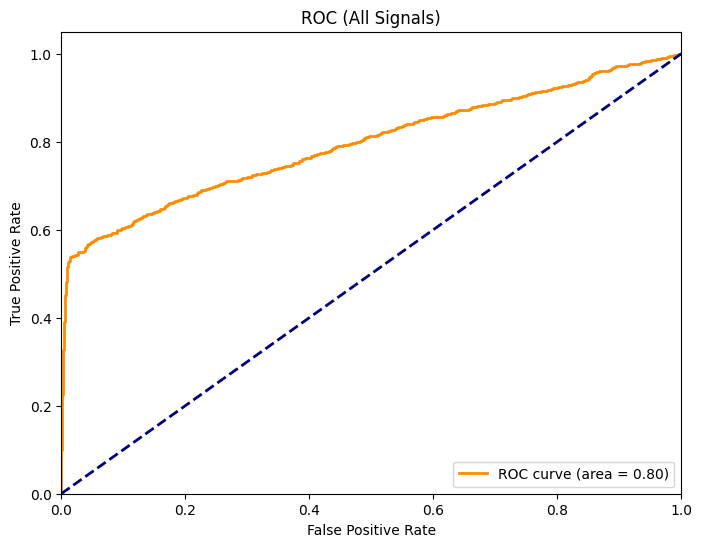

In [17]:
# Compute the ROC curve and AUC using scikit-learn
fpr, tpr, thresholds = roc_curve(all_binary_labels, all_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC (All Signals)")
plt.legend(loc="lower right")
plt.savefig("roc_combined.png")
plt.show()

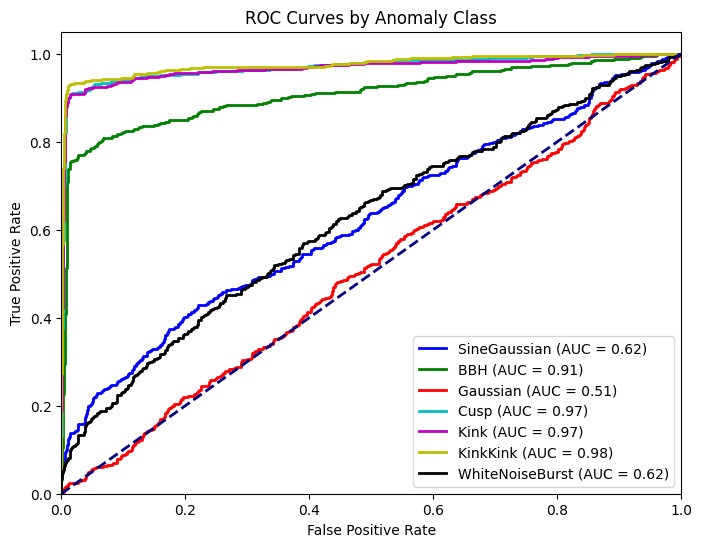

In [18]:
# Compute and plot ROC curves for each anomaly class (all but "Background").

plt.figure(figsize=(8,6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Colors for each anomaly class

for i, anomaly_class in enumerate(signal_classes[:-1]):  # Exclude "Background"
    # The anomaly class numeric label is i+1.
    anomaly_val = i + 1
    # Filter to only examples that are either the current anomaly class or Background (label 8).
    idx = np.where((all_labels == anomaly_val) | (all_labels == 8))[0]
    if idx.size == 0:
        continue  # skip if no examples
    scores_i = all_scores[idx]
    # Create binary ground truth: positive if the example is of the current anomaly class, 0 if background.
    binary_labels = (all_labels[idx] == anomaly_val).astype(int)
    
    # Compute the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(binary_labels, scores_i)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2,
             label=f"{anomaly_class} (AUC = {roc_auc:.2f})")

# Plot reference line (diagonal)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
#plt.yscale('log')
plt.title("ROC Curves by Anomaly Class")
plt.legend(loc="lower right")
plt.savefig("rocs_bySignal.png")
plt.show()

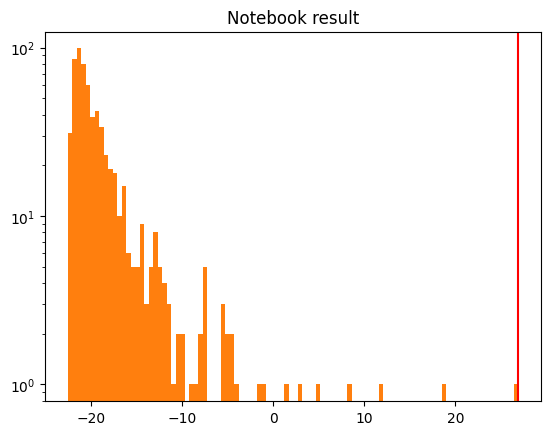

In [19]:
segment_duration = 0.5
year_sec = 3.154e7

fraction_1yr = (1.0 / year_sec) * segment_duration
# # Extract background-only data
bg_mask = (all_labels == 8)
bg_scores = all_scores[bg_mask]
c_bg_scores = c_all_scores[bg_mask]
threshold_1yr= np.quantile(bg_scores,1-fraction_1yr)


# threshold_1yr = 20
plt.title("Notebook result")


h_2 = plt.hist(c_bg_scores,bins=100)
h_1 = plt.hist(bg_scores,bins=100)
plt.axvline(threshold_1yr,color='red')
plt.yscale('log')

SineGaussian [-2.05893211e+01 -1.03053284e+01 -2.10352364e+01 -2.11310425e+01
 -1.53641090e+01 -2.00620041e+01 -2.19326859e+01 -1.76464653e+01
  2.35438156e+00  1.11420944e+02 -2.20785904e+01 -2.06674652e+01
 -2.15507202e+01 -1.99425850e+01 -1.47215919e+01 -1.49426737e+01
  1.61447433e+02 -2.18290520e+01 -2.10196648e+01 -2.18561287e+01
 -1.38995075e+01 -2.07587395e+01 -2.19268456e+01 -1.45322199e+01
 -2.11594582e+01 -2.16567078e+01 -2.20712929e+01 -2.21518478e+01
 -2.18973179e+01  9.33888474e+01 -1.70300808e+01  2.69817867e+01
 -2.11539211e+01 -1.36939478e+01 -2.07179489e+01 -1.94323807e+01
 -2.06725197e+01 -2.07199783e+01 -1.69059353e+01 -1.93198509e+01
 -1.67339211e+01 -2.17266483e+01 -1.78495293e+01 -2.16179123e+01
 -2.07050285e+01 -2.10293465e+01 -1.59073925e+01 -1.73783340e+01
 -2.13955269e+01 -2.14878502e+01 -1.06243954e+01  2.37682705e+01
 -2.04393997e+01 -2.05517693e+01 -2.03449135e+01 -2.06632195e+01
  7.68891602e+01 -2.03480568e+01  5.84285736e+00 -1.92430038e+01
  3.23520126

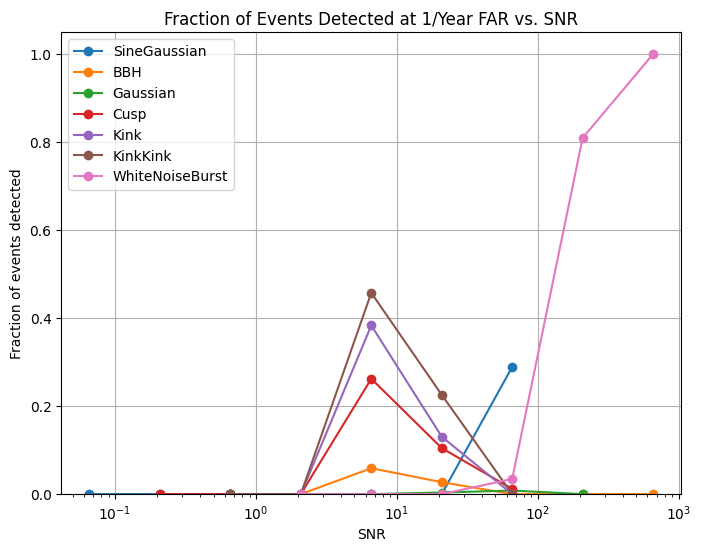

In [20]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
# -----------------------------------------------------------------------------
# 3) BIN ANOMALIES BY SNR AND COMPUTE FRACTION DETECTED (SCORE > threshold_1yr)
# -----------------------------------------------------------------------------

# We'll define 10 bins in SNR from the minimum anomaly SNR to the maximum
# anomaly SNR across all anomaly classes (labels 1..7).
anom_mask = (all_labels != 8)
if np.any(anom_mask):
    snr_min, snr_max = all_snrs[anom_mask].min(), all_snrs[anom_mask].max()
else:
    raise ValueError("No anomaly samples found in the test set!")

snr_min, snr_max = 0, 100

num_bins = 10
bin_edges = np.logspace(-2, 3, num_bins + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.figure(figsize=(8,6))

for i, anom_class_name in enumerate(signal_classes[:-1]):
    class_label = i + 1  # classes are 1..7
    mask = (all_labels == class_label)
    if not np.any(mask):
        # If no samples for that class, skip
        continue

    class_scores = all_scores[mask]
    class_snrs = all_snrs[mask]

    # Bin by SNR
    bin_idx = np.digitize(class_snrs, bin_edges) - 1  # bin indices in [0..num_bins-1]

    frac_detected = []
    for b in range(num_bins):
        in_bin = (bin_idx == b)
        if not np.any(in_bin):
            frac_detected.append(np.nan)  # or 0.0 if you prefer
        else:
            # fraction that exceed threshold
            frac = np.mean(class_scores[in_bin] > threshold_1yr)
            frac_detected.append(frac)

    print(anom_class_name, class_scores)
    plt.plot(bin_centers, frac_detected, marker='o', label=anom_class_name)

plt.xlabel("SNR")
plt.ylabel("Fraction of events detected")
plt.title("Fraction of Events Detected at 1/Year FAR vs. SNR")
plt.ylim([0, 1.05])
plt.xscale('log')
plt.legend()
plt.grid(True)
#plt.savefig("fraction_1overYearFAR_SNR.png")
plt.show()

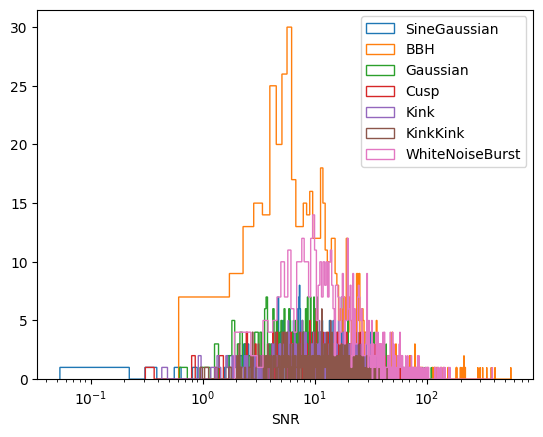

In [21]:
bins = np.logspace(1,7,100)
for i,sig in enumerate(signal_classes[:-1]):
    h=plt.hist(all_snrs[all_labels==i+1],bins=1000,label=sig,histtype='step')
#plt.yscale('log')
plt.xscale('log')
plt.xlabel("SNR")
plt.legend()

In [22]:
for i, sig in enumerate(signal_classes[:-1]):
    snr_min, snr_max = 0, 0
    anom_mask = (all_labels == i+1)
    snr_min, snr_max = all_snrs[anom_mask].min(), all_snrs[anom_mask].max()
    print(sig, snr_min, snr_max)

SineGaussian 0.05327331 84.23065
BBH 0.6111919 561.8103
Gaussian 0.62094057 109.9584
Cusp 0.308304 61.51096
Kink 0.43215775 54.06491
KinkKink 0.9529419 45.32551
WhiteNoiseBurst 1.9236459 385.0374


In [23]:
for i, sig in enumerate(signal_classes[:-1]):
    snr_min, snr_max = 0, 0
    anom_mask = (all_labels == i+1)
    snr_min, snr_max = all_snrs[anom_mask].min(), all_snrs[anom_mask].max()
    print(sig, snr_min, snr_max)

SineGaussian 0.05327331 84.23065
BBH 0.6111919 561.8103
Gaussian 0.62094057 109.9584
Cusp 0.308304 61.51096
Kink 0.43215775 54.06491
KinkKink 0.9529419 45.32551
WhiteNoiseBurst 1.9236459 385.0374
